In [1]:
from pathlib import Path
import time
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import partipy as pt
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt

from data_utils import load_ms_xenium_data

atlas_adata = load_ms_xenium_data()
print(atlas_adata)

## remap the cell type annotation to broader categories
mapping_dict = {
    "MP/MiGl_1": "Myeloid",
    "MP/MiGl_2": "Myeloid",
    "vascular_MP_1":"Myeloid",
    "vascular_MP_2": "Myeloid",
    "vascular_MP_3": "Myeloid",
    "Vascular_1": "Vascular",
    "Vascular_2": "Vascular",
    "Astro_WM": "Astrocyte",
    "Astro_GM": "Astrocyte",
    "Astro_WM_DA": "Astrocyte",
    "Astro_GM_DA": "Astrocyte",
    "OLG_WM": "Oligo",
    "OLG_WM_DA": "Oligo",
    "OLG_GM": "Oligo",
    "OPC": "OPC",
    "OPC_DA": "OPC",
    "COP": "COP",
    "NFOL/MFOL": "NFOL",
    "Schw": "Schwann",
    "Endo": "Endothelial",
    "Neurons": "Neurons",
    "vascular_T-cell": "T_cell",
    "T-cell": "T_cell",
    "Ependymal": "Ependymal",
    "unknown": "unknown",
}

atlas_adata.obs["celltype"] = atlas_adata.obs["Level2"].map(mapping_dict)

Zip file already exists: data/MS_xenium_data_v5_with_images_tmap.h5ad.zip
Extracted H5AD file already valid: data/MS_xenium_data_v5_with_images_tmap.h5ad
AnnData object with n_obs × n_vars = 660801 × 266
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'n_counts', 'batch', 'type', 'type_spec', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'project', 'rotate', 'flip', 'Level0', 'reclustered_Level0', 'x_rotated_2', 'y_rotated_2', 'sex', 'age', 'y_rotated_mod', 'x_rotated_mod', 'Level1', 'Level2', 'Level3', 'compartment', 'compartment_2', 'compartment_2_colors', 'region_area', 'Level1_5', 'library_id'
    uns: 'Level0_colors', 'Level0_wilcoxon', 'Level1_5_colors', 'Level1_5_wilcoxon', 'Level1_colors', 'Level1_wilcoxon', 'Level2_colors', 'Level2_wilcoxon', 'Level3_colors', 'Level3_wilcoxon', 'age_colors', 'compart

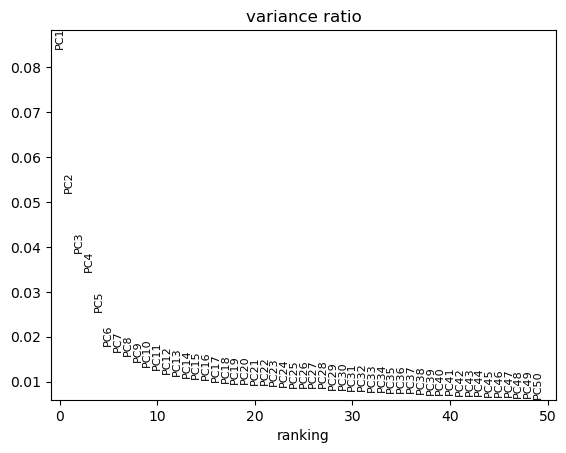

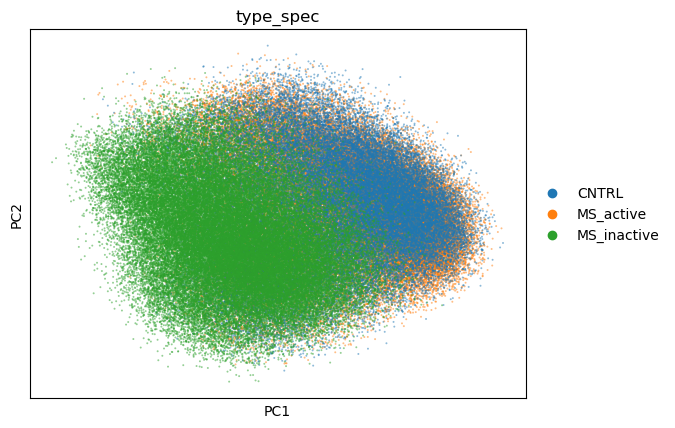

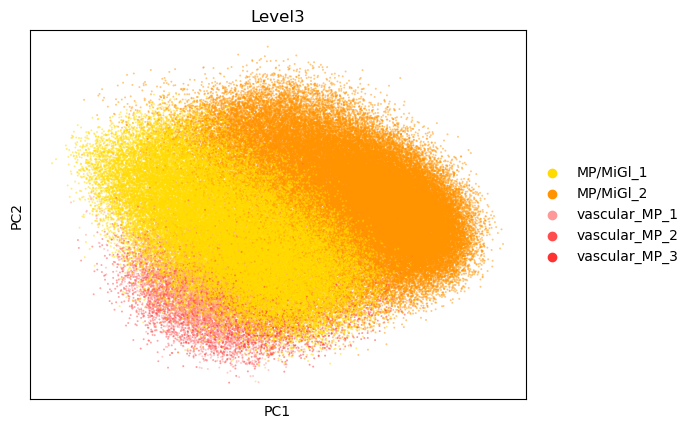

In [2]:
celltype_column = "celltype"
celltype = "Myeloid"
n_archetypes = 4
qc_columns = ["type_spec", "Level3"]

## subsetting and preprocessing per celltype
## NOTE: For Xenium data we do not need to select highly variable genes before PCA
adata = atlas_adata[atlas_adata.obs[celltype_column]==celltype, :].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

## some scanpy QC plots
for qc_var in qc_columns:
    adata.obs[qc_var] = pd.Categorical(adata.obs[qc_var])

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False, show=True, save=False)

sc.pl.pca(adata, color=qc_columns[0], size=8, alpha=0.50, show=True, save=False)

sc.pl.pca(adata, color=qc_columns[1], size=8, alpha=0.50, show=True, save=False)

## for simplicity we will always use 10 principal components
pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimension=10)

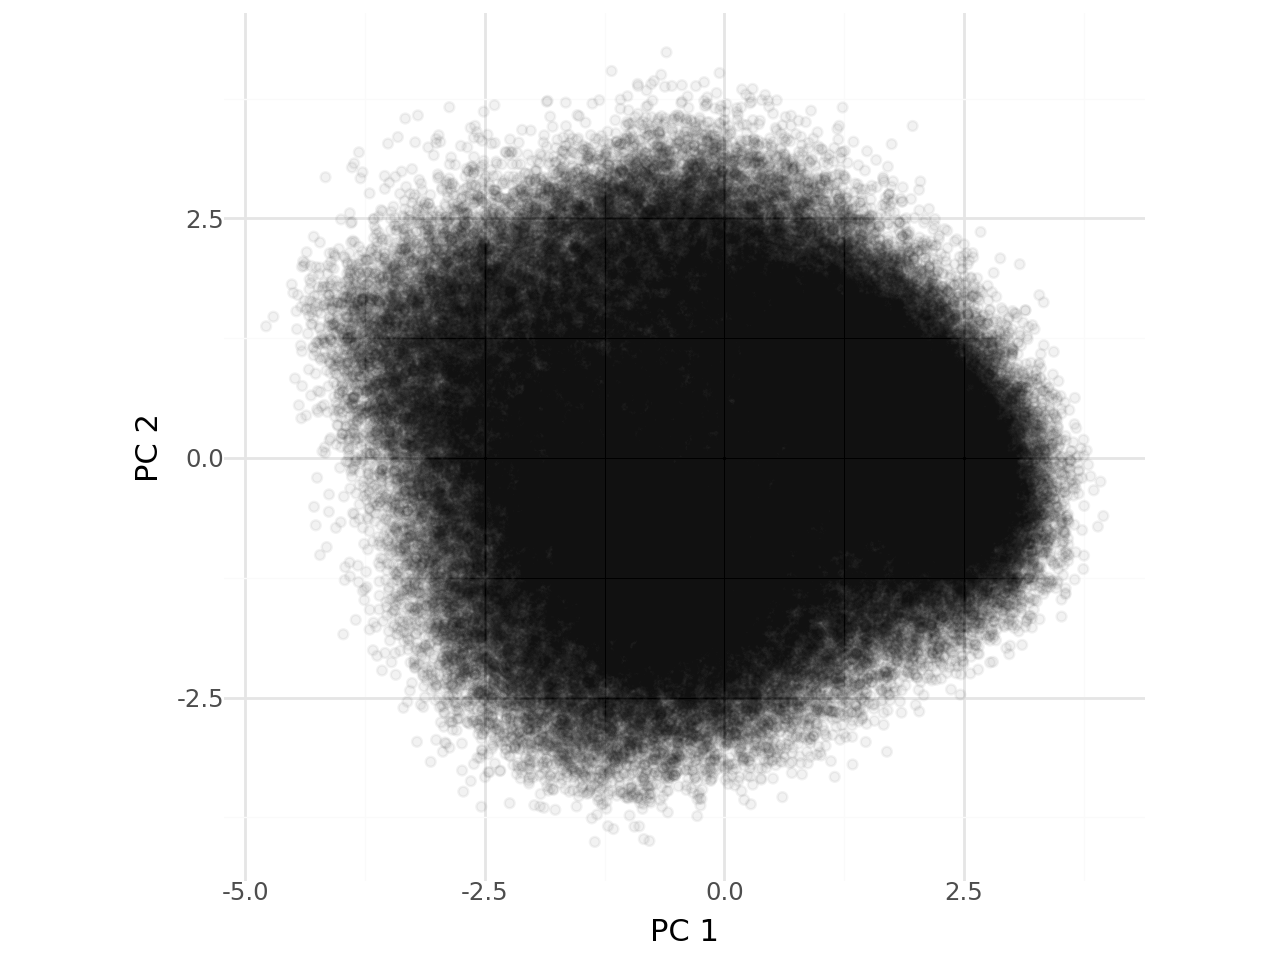

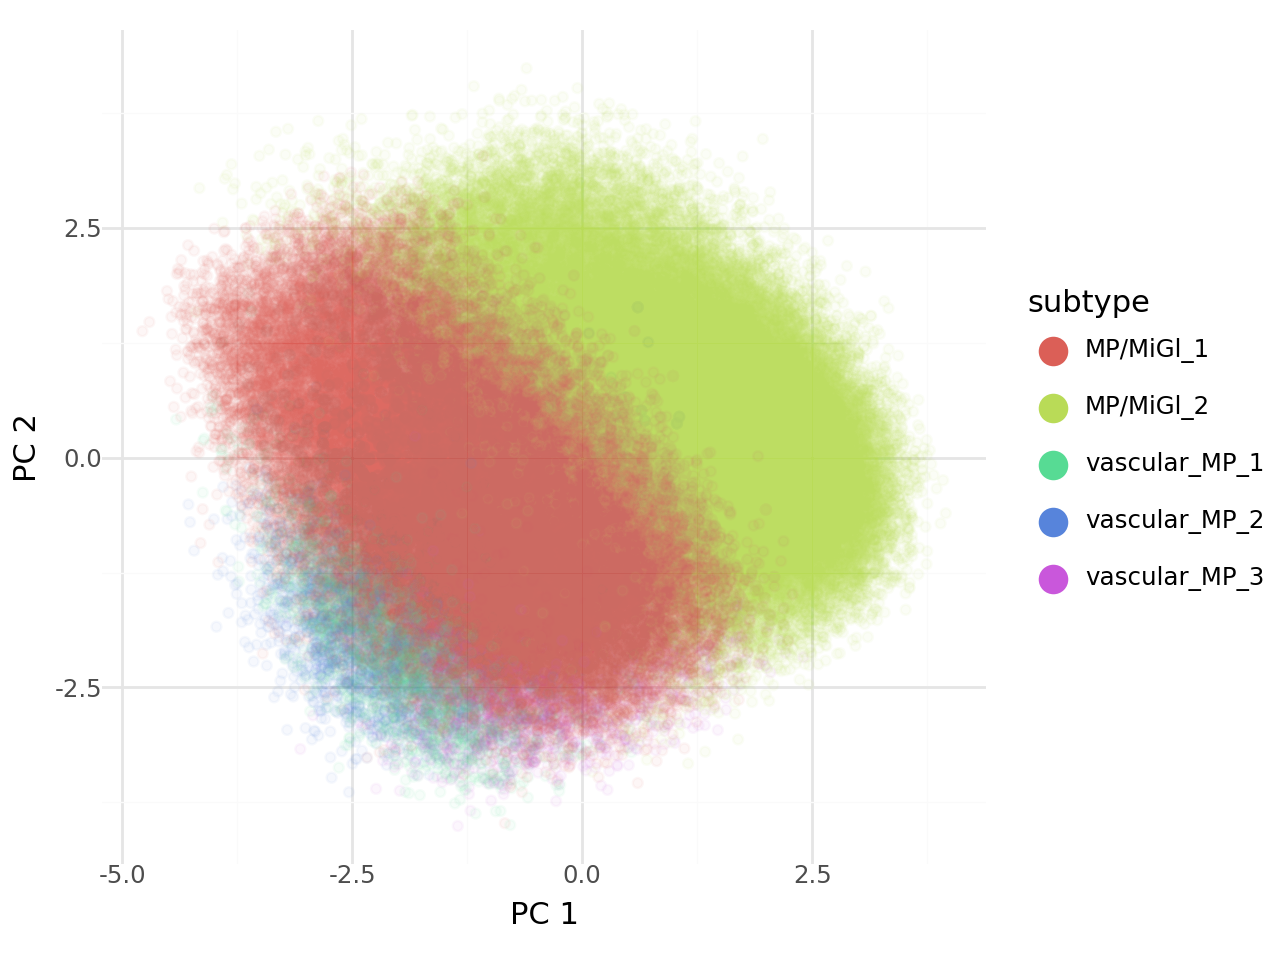

In [3]:
plot_df = pd.DataFrame({"x": adata.obsm["X_pca"][:, 0], 
                        "y": adata.obsm["X_pca"][:, 1],
                        "subtype": adata.obs["Level3"]})

p = (pn.ggplot(plot_df)
     + pn.geom_point(pn.aes(x="x", y="y"), alpha=0.05)
     + pn.coord_equal()
     + pn.labs(x="PC 1", y="PC 2")
     + pn.theme_minimal()
    )
p.show()

p = (pn.ggplot(plot_df)
     + pn.geom_point(pn.aes(x="x", y="y", color="subtype"), alpha=0.05)
     + pn.coord_equal()
     + pn.labs(x="PC 1", y="PC 2")
     + pn.theme_minimal()
     + pn.guides(color=pn.guide_legend(override_aes={"alpha": 1, "size": 5}))
    )
p.show()

In [7]:
pt.compute_archetypes(adata, 
                      n_archetypes=n_archetypes,
                      weight=None,
                      seed=0,
                      save_to_anndata=True,
                      archetypes_only=False,
                      verbose=False)
pt.compute_archetype_weights(adata)

Applied length scale is 2.1117720104811872.


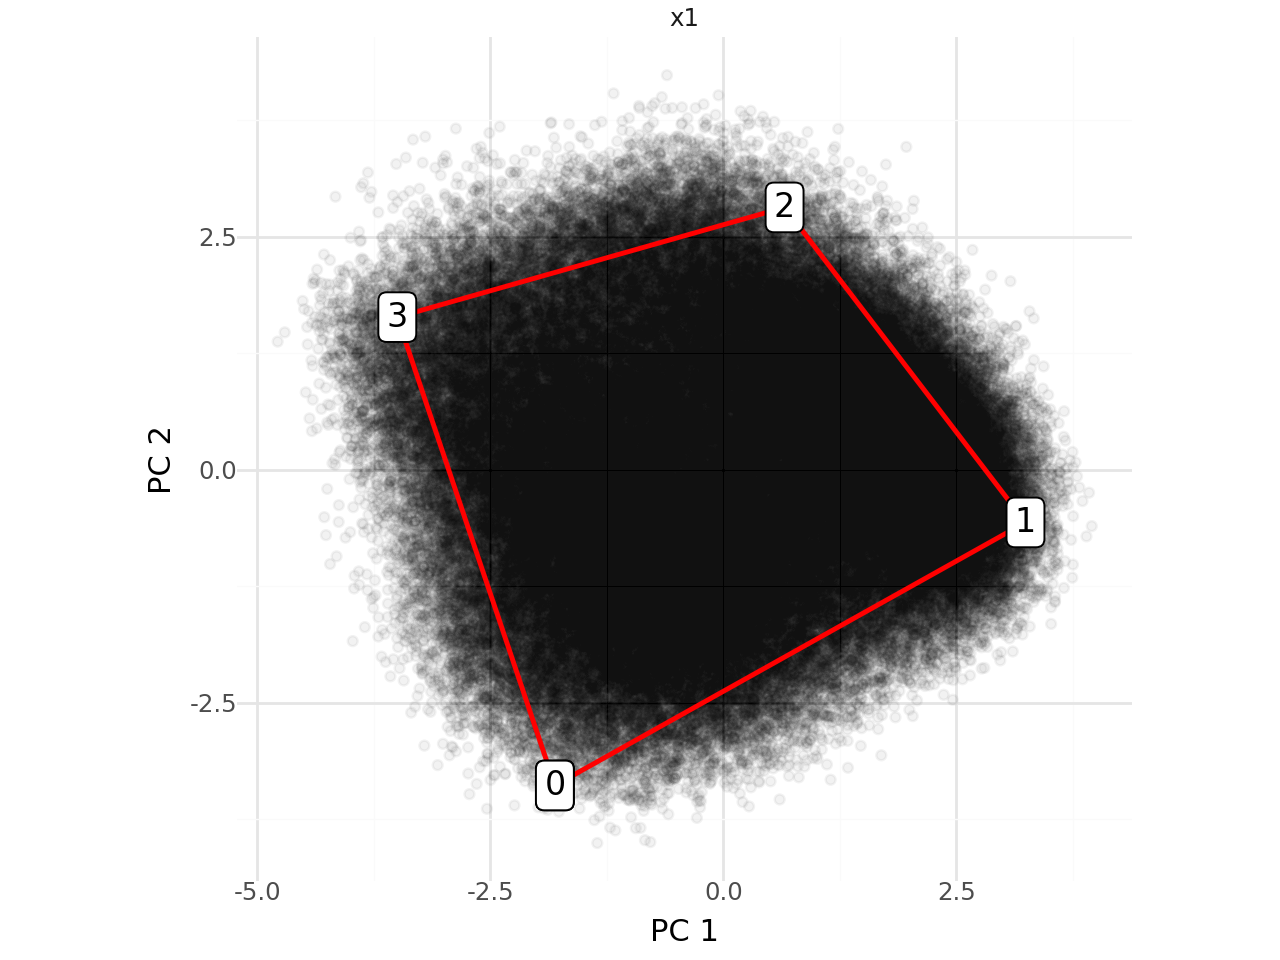

In [5]:
pt.plot_archetypes_2D(adata, alpha=0.05, show_two_panels=False) + pn.labs(x="PC 1", y="PC 2") + pn.theme_minimal()

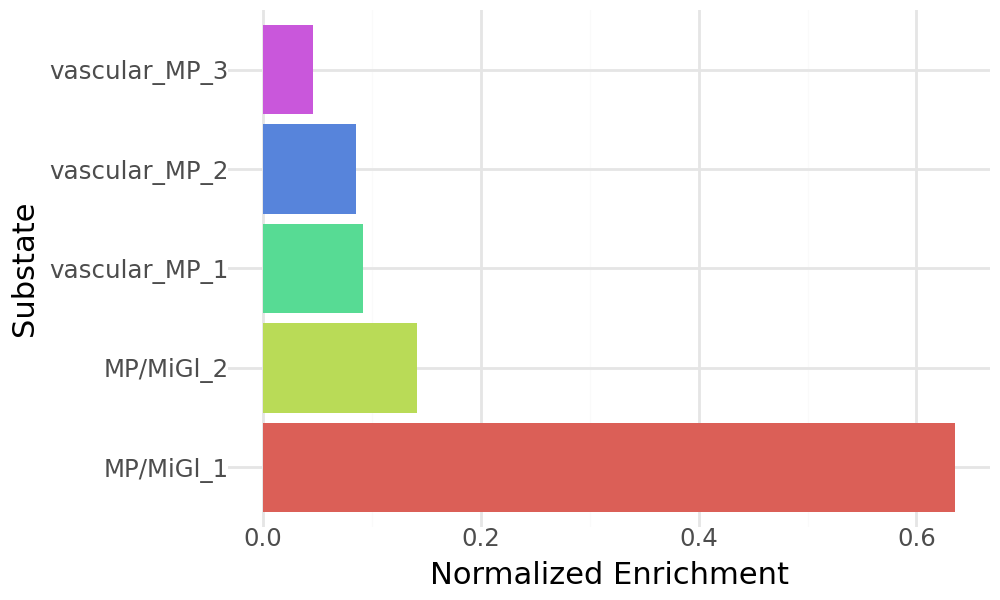

In [55]:
enrichment_df = pt.compute_meta_enrichment(adata, meta_col="Level3")
p = pn.ggplot(enrichment_df.iloc[3, :].reset_index(name="proportion")) + pn.geom_col(pn.aes(x="index", y="proportion", fill="index")) + pn.coord_flip() + pn.theme_minimal() + pn.labs(y="Normalized Enrichment", x="Substate") + pn.theme(figure_size=(5, 3)) + pn.guides(fill=False)
p.show()

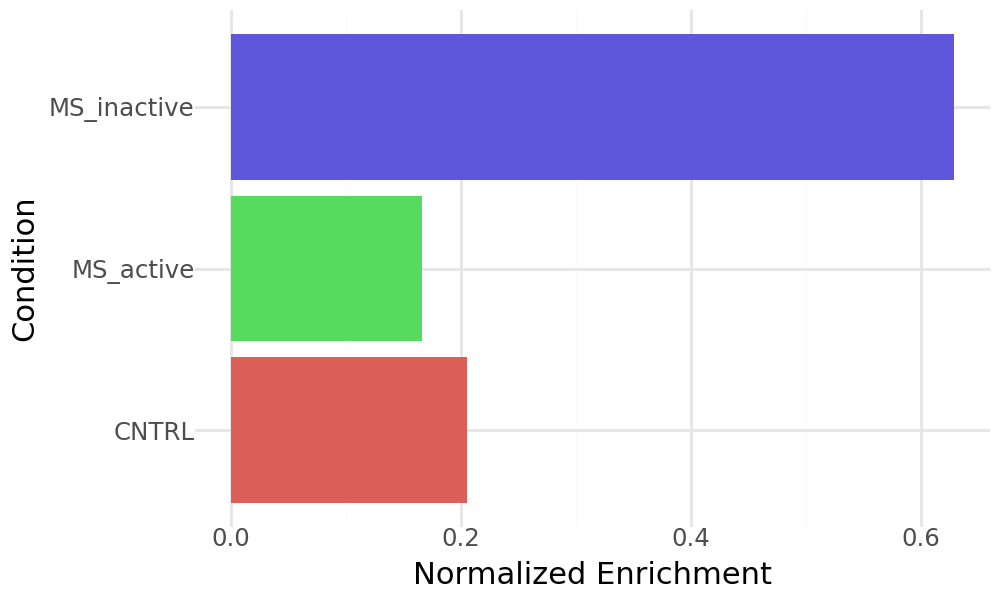

In [56]:
enrichment_df = pt.compute_meta_enrichment(adata, meta_col="type_spec")
p = pn.ggplot(enrichment_df.iloc[3, :].reset_index(name="proportion")) + pn.geom_col(pn.aes(x="index", y="proportion", fill="index")) + pn.coord_flip() + pn.theme_minimal() + pn.labs(y="Normalized Enrichment", x="Condition") + pn.theme(figure_size=(5, 3)) + pn.guides(fill=False)
p.show()

Applied length scale is 2.1117720104811872.


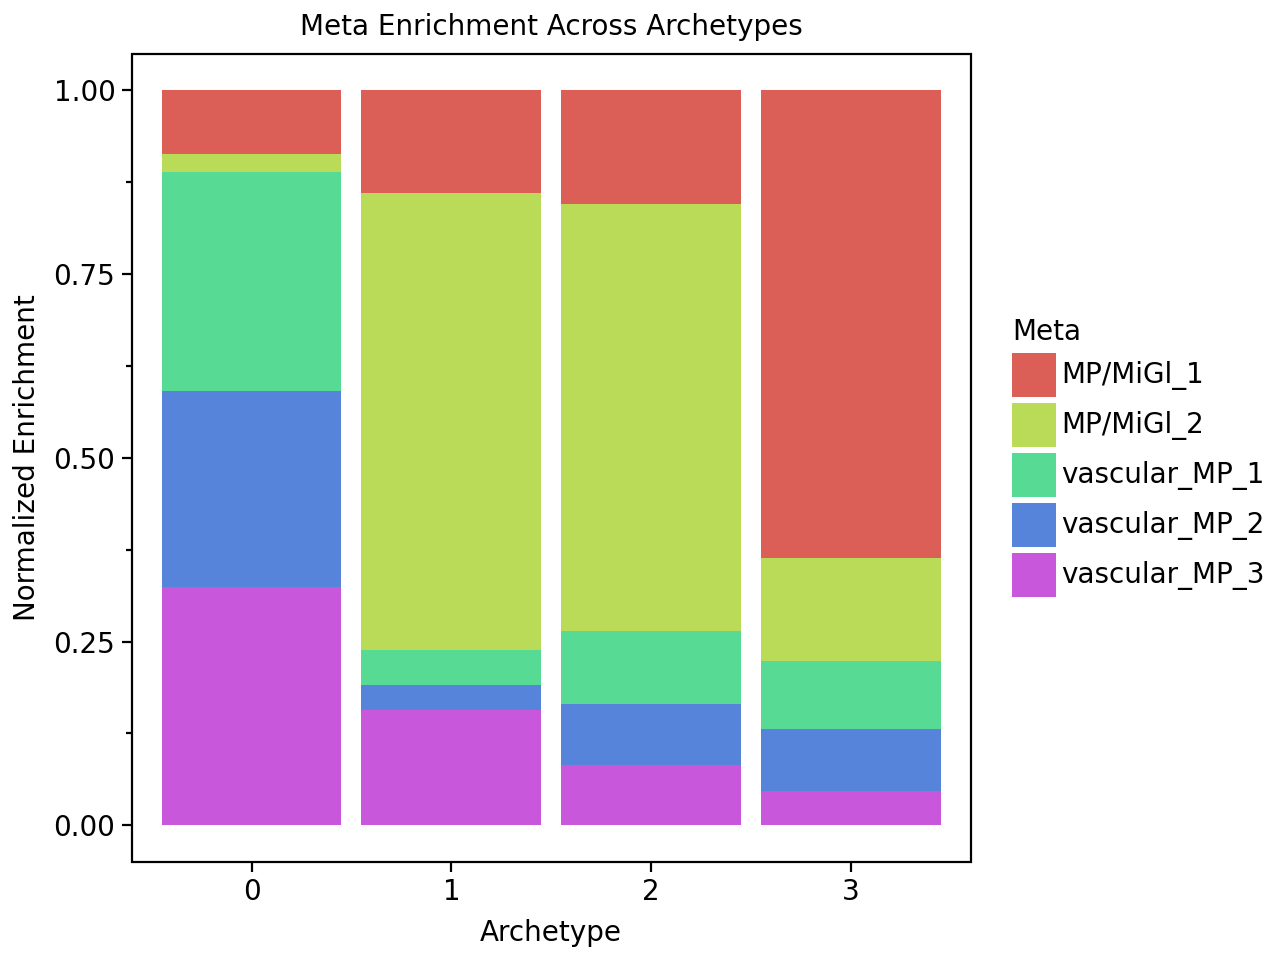

In [9]:
pt.compute_archetype_weights(adata)
enrichment_df = pt.compute_meta_enrichment(adata, meta_col="Level3")
pt.barplot_meta_enrichment(enrichment_df)

Applied length scale is 2.1117720104811872.


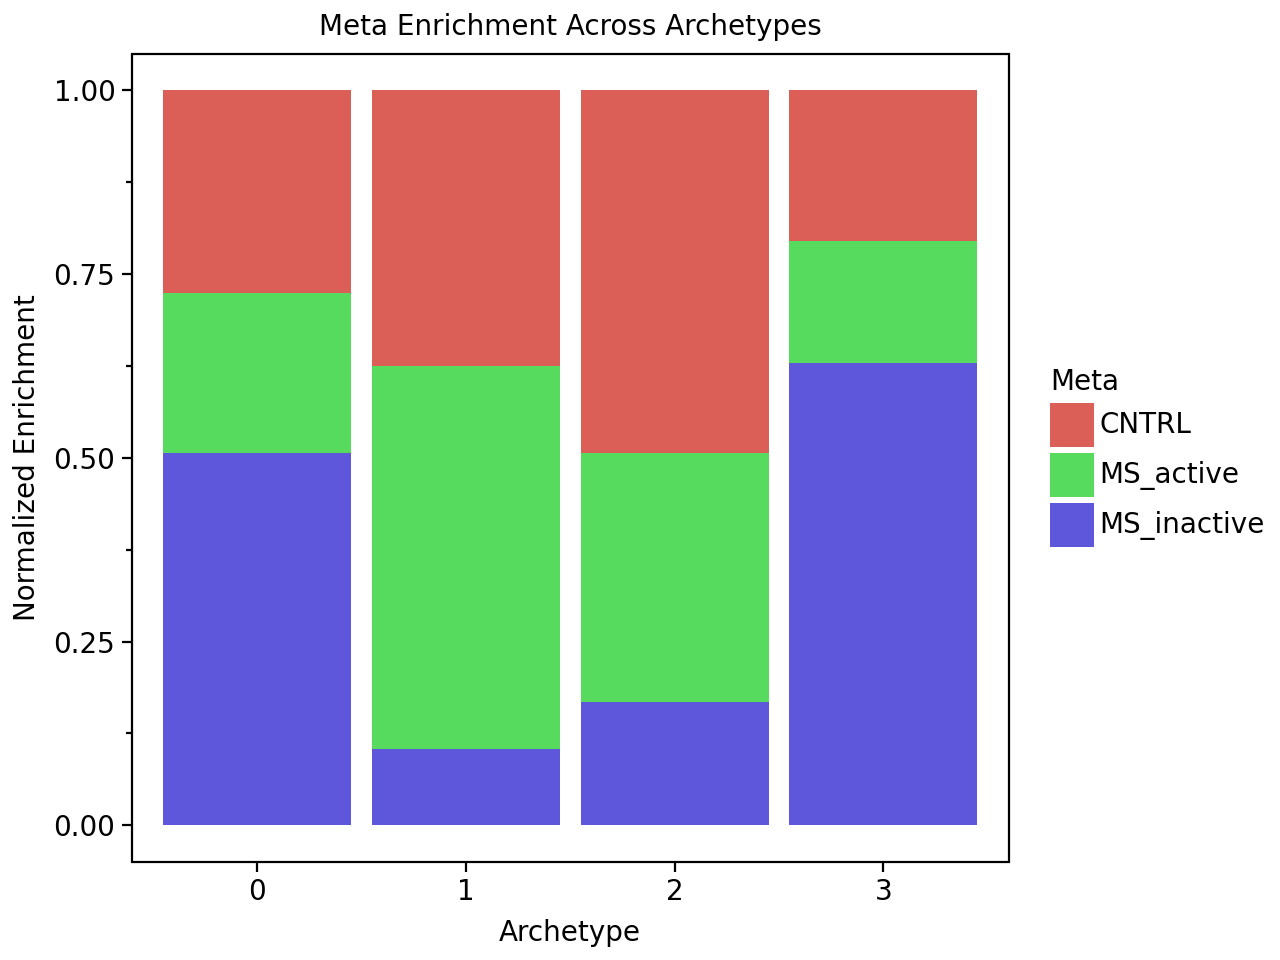

In [10]:
pt.compute_archetype_weights(adata)
enrichment_df = pt.compute_meta_enrichment(adata, meta_col="type_spec")
pt.barplot_meta_enrichment(enrichment_df)

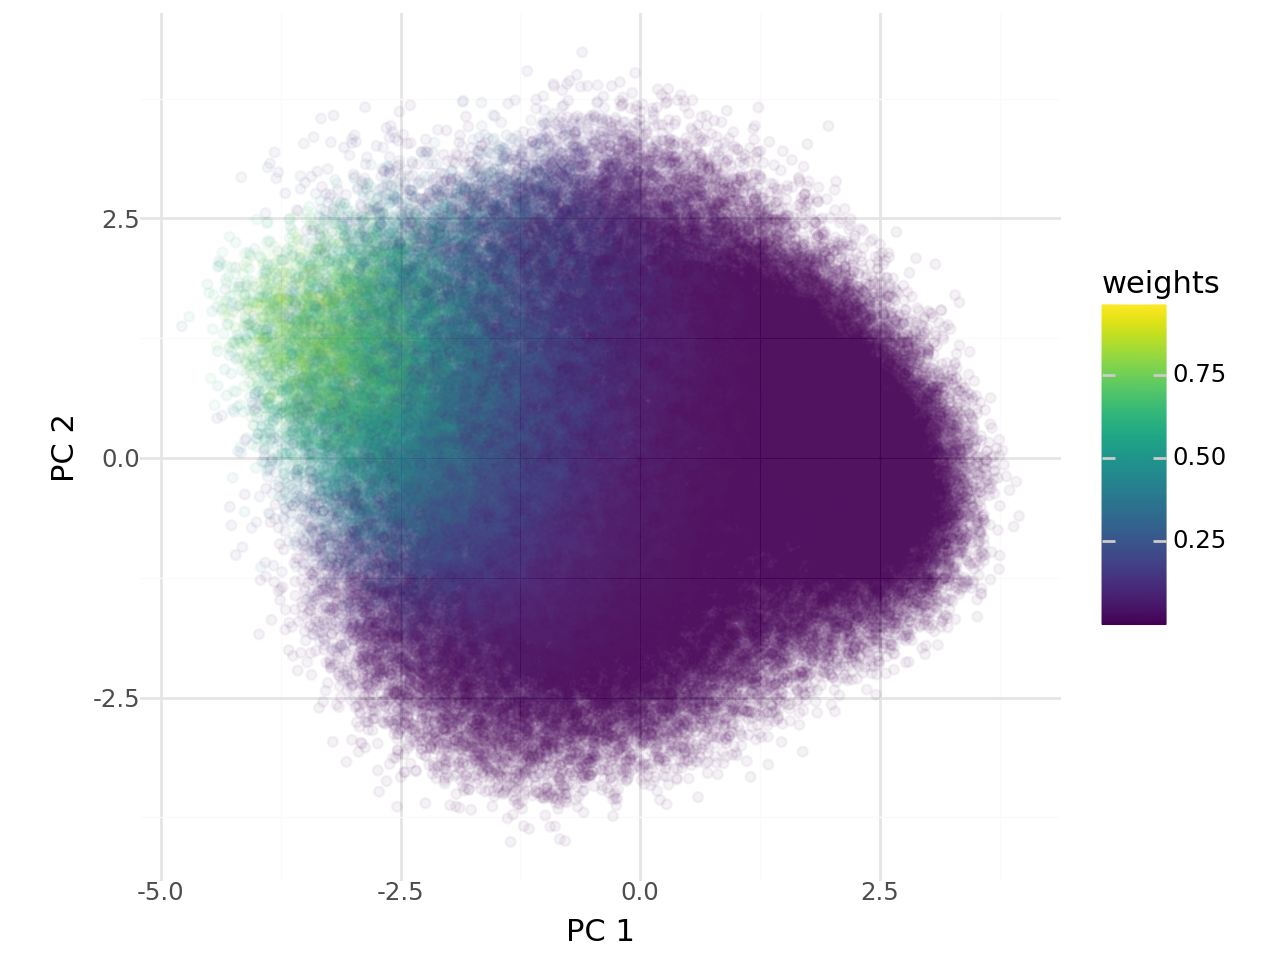

In [11]:
plot_df = pd.DataFrame({"x": adata.obsm["X_pca"][:, 0], 
                        "y": adata.obsm["X_pca"][:, 1],
                        "weights": adata.obsm["cell_weights"][:, 3]})

p = (pn.ggplot(plot_df)
     + pn.geom_point(pn.aes(x="x", y="y", color="weights"), alpha=0.05)
     + pn.coord_equal()
     + pn.labs(x="PC 1", y="PC 2")
     + pn.theme_minimal()
    )
p.show()

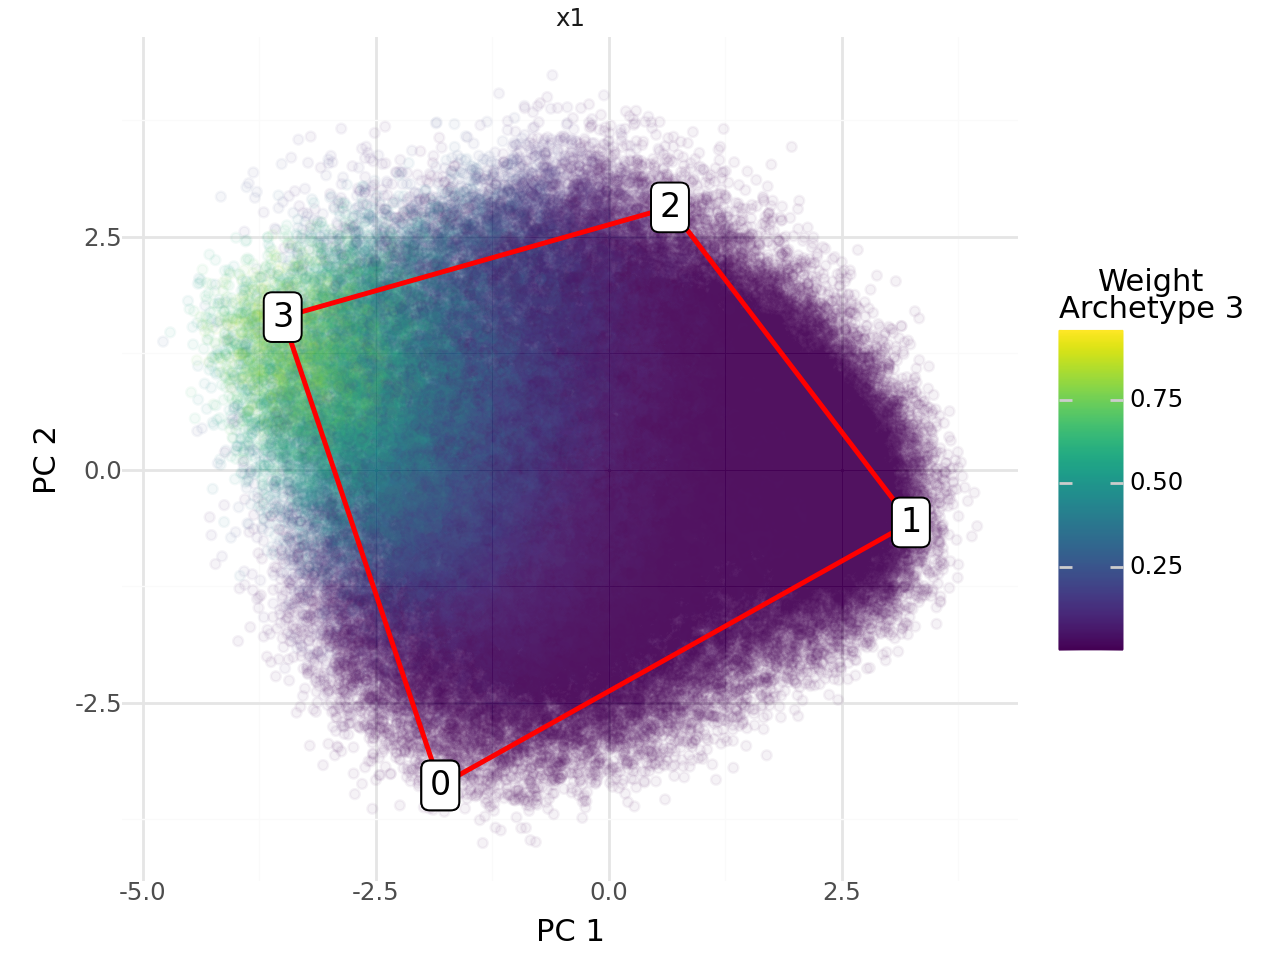

In [12]:
adata.obs["weights_aa"] = adata.obsm["cell_weights"][:, 3]
p = pt.plot_archetypes_2D(adata, alpha=0.05, color="weights_aa", show_two_panels=False) + pn.theme_minimal() + pn.labs(x="PC 1", y="PC 2", color="Weight\nArchetype 3")
p.show()

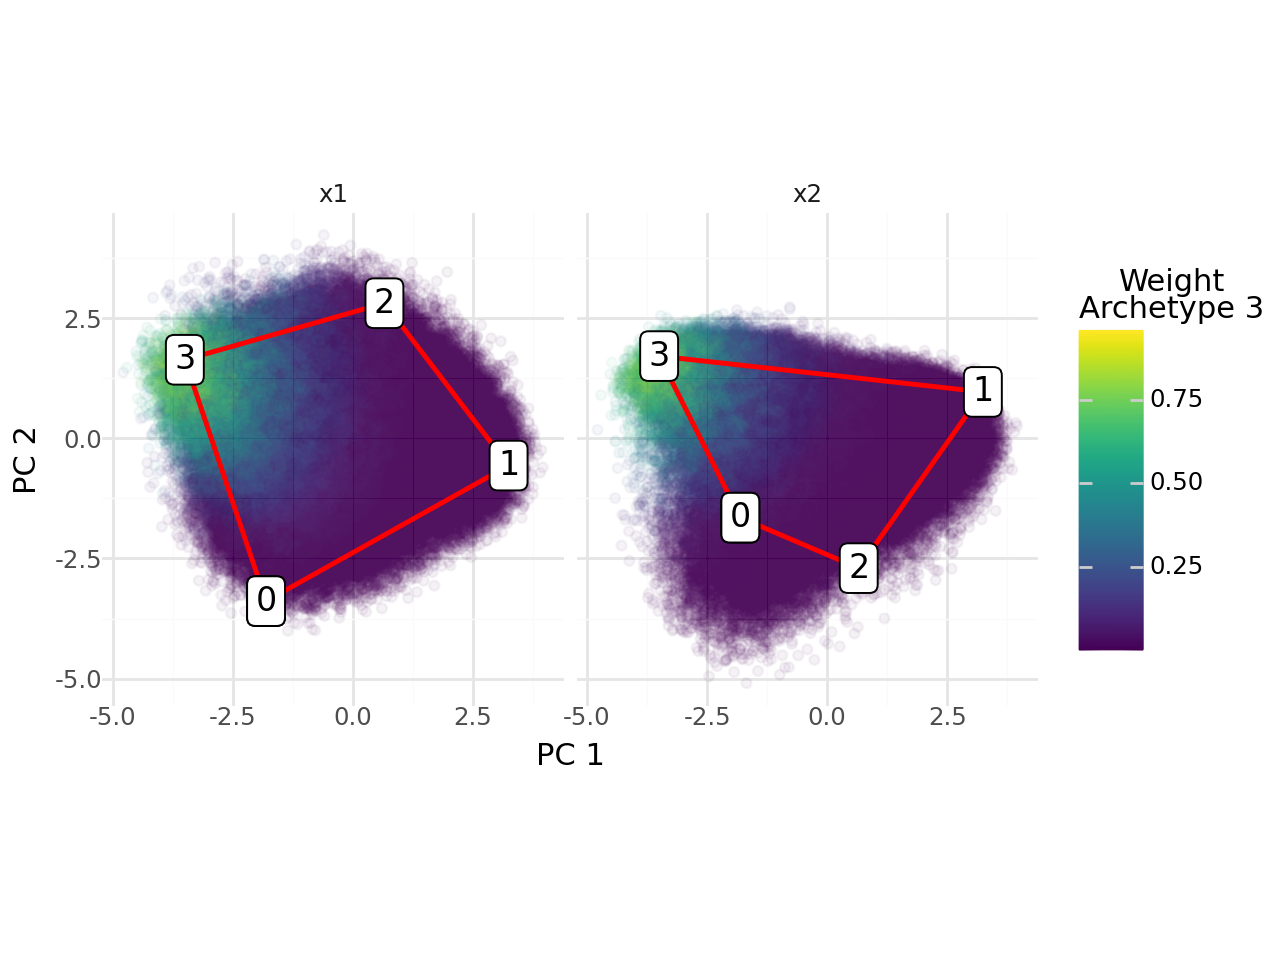

In [13]:
adata.obs["weights_aa"] = adata.obsm["cell_weights"][:, 3]
p = pt.plot_archetypes_2D(adata, alpha=0.05, color="weights_aa", show_two_panels=True) + pn.theme_minimal() + pn.labs(x="PC 1", y="PC 2", color="Weight\nArchetype 3")
p.show()

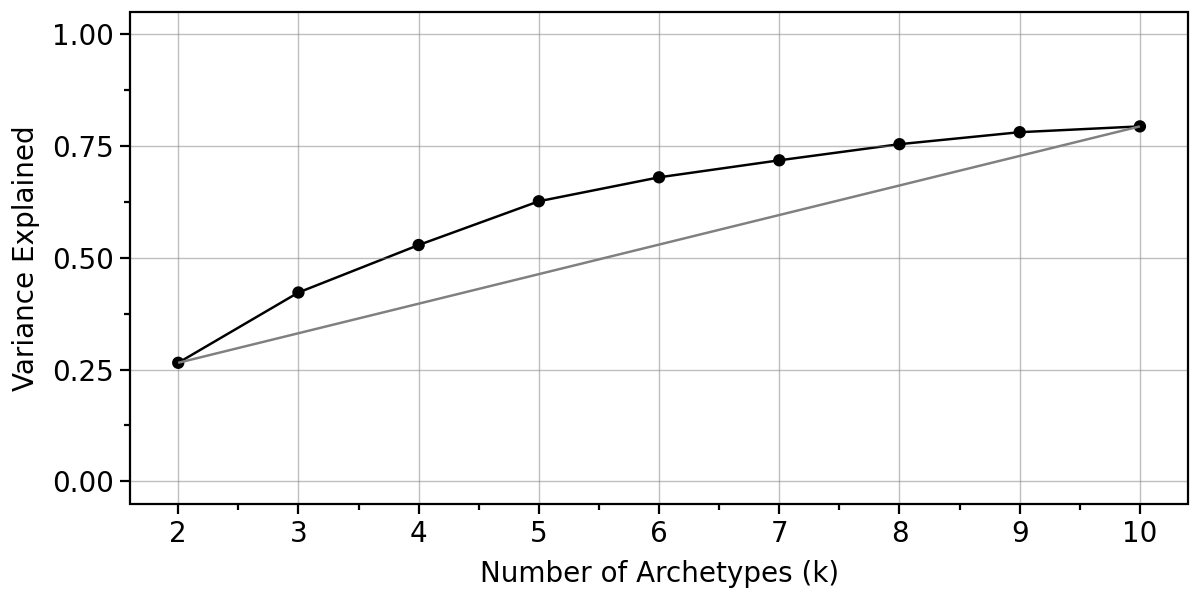

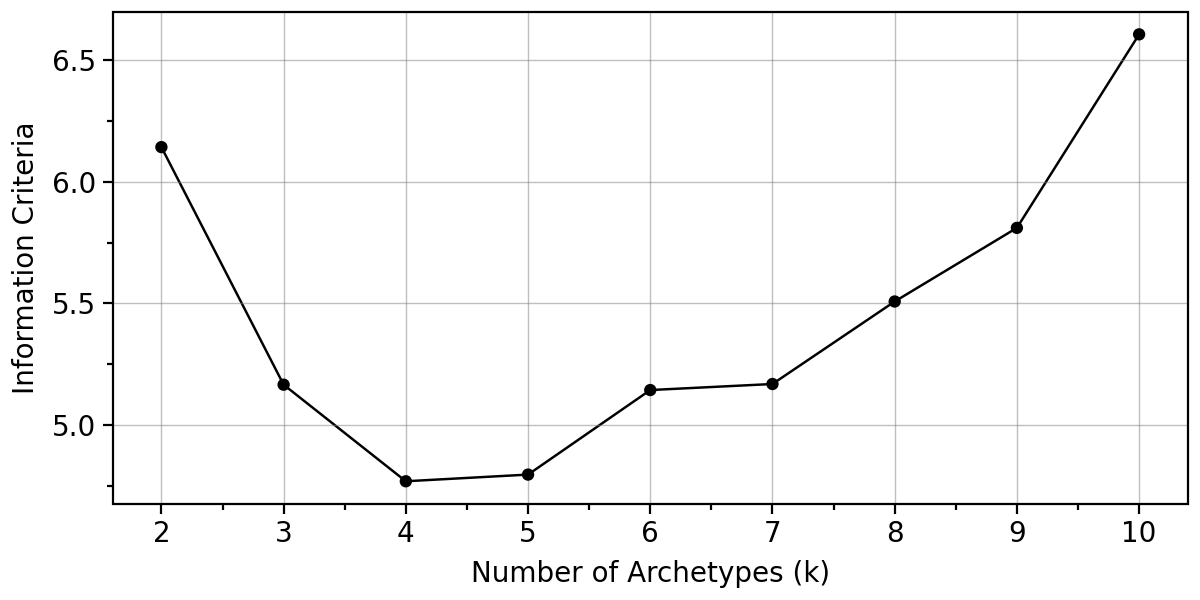

In [14]:
pt.compute_selection_metrics(adata=adata, min_k=2, max_k=10, n_jobs=20)

p = pt.plot_var_explained(adata)
p.show()

p = pt.plot_IC(adata)
p.show()

In [24]:
# takes 15 min to run!
pt.compute_bootstrap_variance_multiple_k(adata=adata, n_archetypes_list=list(range(2, 11)), n_bootstrap=20)
p = pt.plot_bootstrap_multiple_k(adata)
p.show()

KeyboardInterrupt: 

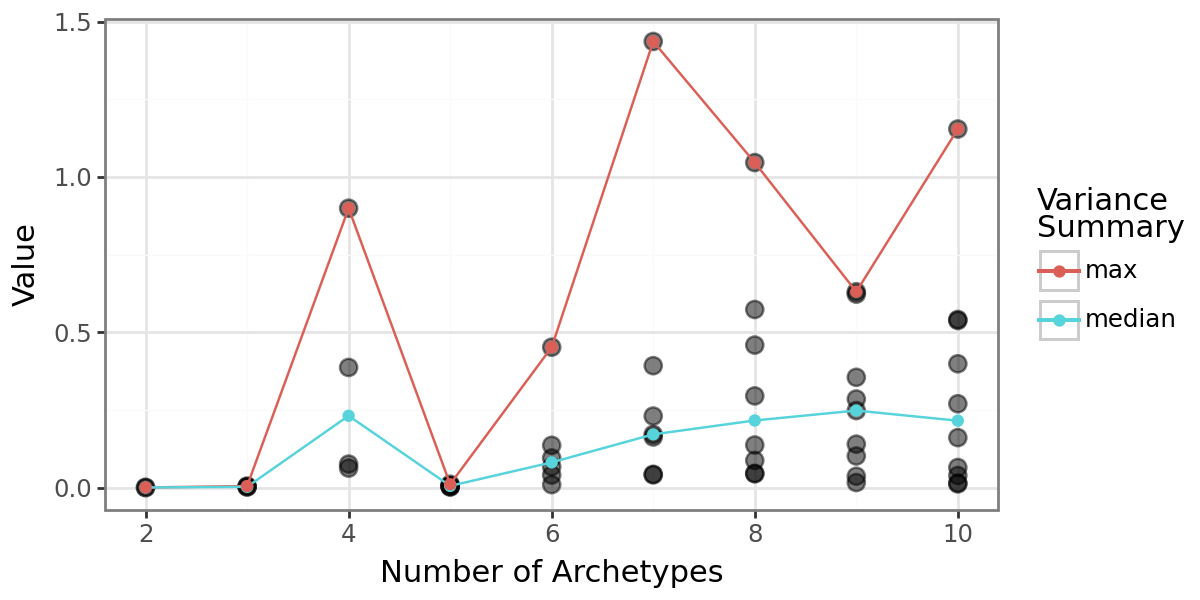

In [27]:
p = pt.plot_bootstrap_multiple_k(adata) + pn.theme_bw() + pn.theme(figure_size=(6, 3))
p.show()

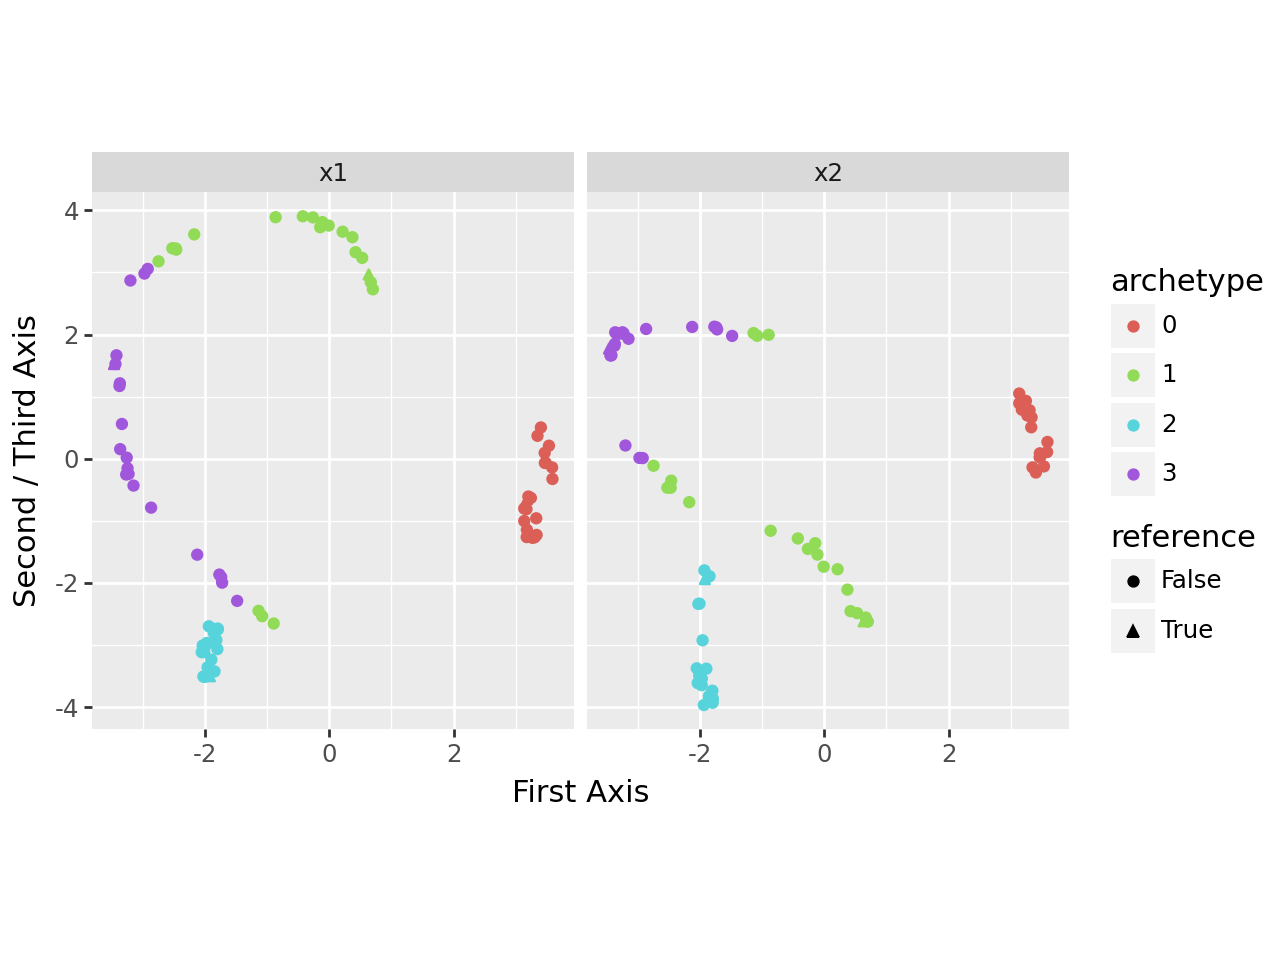

In [20]:
pt.compute_bootstrap_variance(adata=adata, n_bootstrap=20, n_archetypes=n_archetypes, n_jobs=20)
p = pt.plot_bootstrap_2D(adata)
p.show()

In [21]:
adata.write("presentation_adata.h5ad")